# Multi-Layer Perceptron, MNIST

The process will be broken down into the following steps:

1. Load and visualize the data
2. Define the network architecture
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch

In [3]:
from torchvision import datasets
from torchvision.transforms import transforms

In [4]:
import torch.nn as nn
import torch.nn.functional as F

In [5]:
num_workers = 0
batch_size = 32
# percentage of training set to be set as validation
valid_size = .2

In [6]:
transform = transforms.ToTensor()

In [7]:
data_train = datasets.MNIST(root= 'data', train= True, download= True, transform= transform)
data_test = datasets.MNIST(root= 'data', train= False, download= True, transform= transform)


In [8]:
type(data_train)

torchvision.datasets.mnist.MNIST

In [9]:
loader_train = torch.utils.data.DataLoader(data_train, batch_size = batch_size, num_workers = num_workers)
loader_test = torch.utils.data.DataLoader(data_test, batch_size = batch_size, num_workers = num_workers)

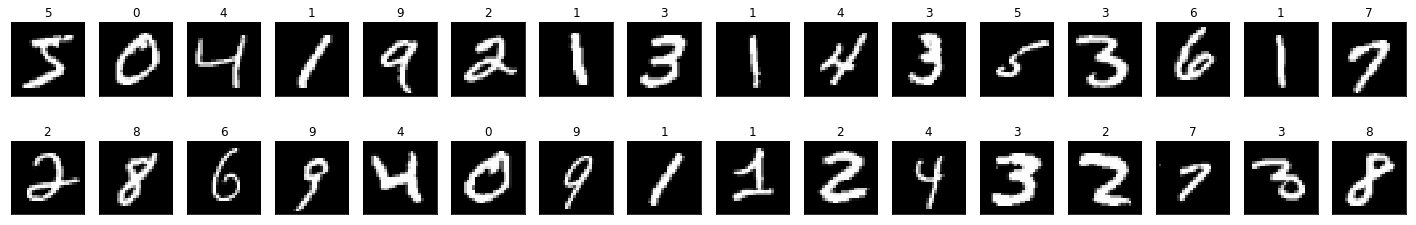

In [10]:
# obtain one batch of training images
dataiter = iter(loader_train)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for ix in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size / 2, ix+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[ix]), cmap='gray')
    ax.set_title(str(labels[ix].item()))

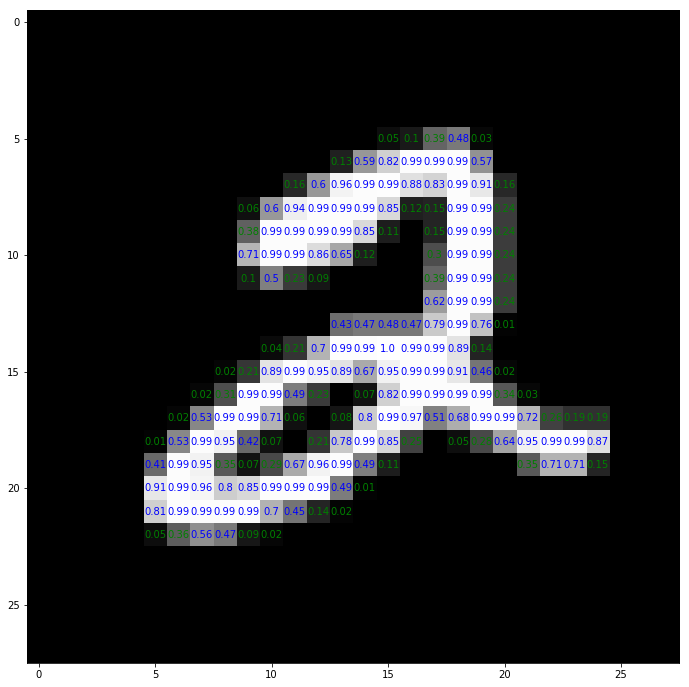

In [11]:
img = np.squeeze(images[5])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for w in range(width):
    for h in range(height):
        val = round(img[w][h],2) if img[w][h] !=0 else ''
        ax.annotate(str(val), xy=(h, w),
                    # ha: horizontalalignment | va: vertical
                    ha='center', va= 'center',
                    color='green' if img[w][h] < thresh else 'blue')

## Define the Network Architecture 

In [12]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        
        # Set the number of hidden units in each layer
        hidden1 = 512
        hidden2 = 512
        # The input is a 28 x 28 image, gray scale
        n_feats = 28 * 28
        # The output has 10 class (0-9)
        n_out = 10
        
        self.fc1 = nn.Linear(n_feats, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, n_out)
        # Kill 20% of the connection in the dropout layer
        self.dropout = nn.Dropout(.2)
        
    def forward(self, x):
        # Flatten the image
        x = x.view(-1, 28 * 28)
        # Run the forward pass
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        # Last layer doesn't need an activation function
        # because I'm going to use the cross enropy loss
        # This, according to pytorch, applies log-softmax and NLLL both.
        x = self.fc3(x)
        
        return x

In [13]:
# Initialize the Net
model = SimpleNet()
# See if the model configuration is as expected
print(model)

SimpleNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


## Specify Loss Function and Optimizer

It's recommended to use cross-entropy loss for classification. PyTorch's cross entropy function applies a softmax funtion to the output layer and then calculates the log loss.

In [14]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

In [15]:
# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr= .03)

## Train the Network

Each training epoch is consisted of the following steps:

1. __Clear the gradients__ of all optimized variables
2. __Forward pass__: make your prediction
3. __Calculate the loss__: how off the prediction is from the truth
4. __Backward pass__: compute gradient of the loss with respect to model parameters
5. __Update the parameters__: perform a single optimization step Update average training loss

In [16]:
n_epochs = 5

# Prep the model for the training phase
model.train()

for e in range(n_epochs):
    loss_train = 0
    
    for data, target in loader_train:
        # For every batch run the 5 steps mentioned above:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        loss_train += loss.item() * data.size(0)
        
    loss_train = loss_train / len(loader_train.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        e + 1, 
        loss_train
        ))

Epoch: 1 	Training Loss: 0.606518
Epoch: 2 	Training Loss: 0.240009
Epoch: 3 	Training Loss: 0.170534
Epoch: 4 	Training Loss: 0.135676
Epoch: 5 	Training Loss: 0.111139


## Test the Trained Network

In machine learning, all that matters is how our model performs on future unseen data. That's why to have a sense of future performance of the model, it's mandatory to set aside a test-set that is only used for this purpose, i.e., test-set is used only once.

In [17]:
loss_test = 0

class_correct = [0 for _ in range(10)]
class_total = [0 for _ in range(10)]

In [18]:
# Prep the model for evaluation phase
# This will deactivate the dropout layer, for example.
model.eval()

for data, target in loader_test:
    output = model(data)
    loss = criterion(output, target)
    loss_test += loss.item() * data.size(0)
    
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        
        class_total[label] += 1


In [19]:
# calculate and print avg test loss
loss_test = loss_test / len(loader_test.sampler)
print('Test Loss: {:.6f}\n'.format(loss_test))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' %(classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.099750

Test Accuracy of     0: 98% (966/980)
Test Accuracy of     1: 99% (1124/1135)
Test Accuracy of     2: 95% (989/1032)
Test Accuracy of     3: 96% (976/1010)
Test Accuracy of     4: 97% (957/982)
Test Accuracy of     5: 98% (878/892)
Test Accuracy of     6: 96% (921/958)
Test Accuracy of     7: 96% (988/1028)
Test Accuracy of     8: 95% (927/974)
Test Accuracy of     9: 95% (963/1009)

Test Accuracy (Overall): 96% (9689/10000)


## Visualize Sample Test Results

In [22]:
# obtain one batch of test images
dataiter = iter(loader_test)

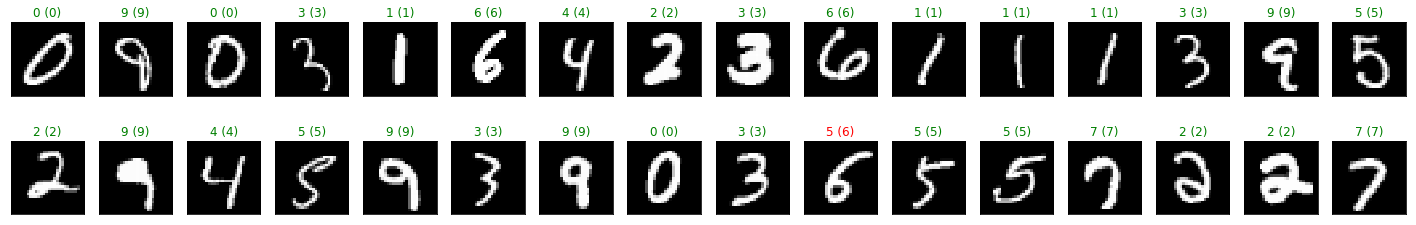

In [29]:

images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for ix in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, ix+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[ix]), cmap='gray')
    ax.set_title('{} ({})'.format(str(preds[ix].item()), str(labels[ix].item())),
                 color=('green' if preds[ix] == labels[ix] else 'red'))